In [3]:
import duckdb

# Connect to DuckDB
con = duckdb.connect()

tpch_tables = [
    'customer',
    'lineitem',
    'nation',
    'orders',
    'part',
    'partsupp',
    'region',
    'supplier'
]

# Load the Parquet files back into DuckDB
for table in tpch_tables:
    con.execute(f"CREATE TABLE {table} AS SELECT * FROM parquet_scan('./data/{table}.parquet')")


In [4]:
import time
import psutil
import os

# Function to measure CPU and memory usage
def measure_performance():
    process = psutil.Process(os.getpid())
    cpu_times = process.cpu_times()
    memory_info = process.memory_info()
    return {
        'cpu_user_time': cpu_times.user,
        'cpu_system_time': cpu_times.system,
        'memory_rss': memory_info.rss,
        'memory_vms': memory_info.vms
    }

## QUERY 1

In [5]:
query1 = """
SELECT
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= DATE '1998-12-01' - INTERVAL 90 DAY
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;
"""
# Start measuring performance

start_perf = measure_performance()  

start_time = time.time()
result1 = con.execute(query1).fetchdf()
# Calculate execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

# Get current CPU usage as a percentage
cpu_usage = psutil.cpu_percent(interval=1)
print(f"Current CPU Usage: {cpu_usage}%")

# Get current memory usage in MB
memory_usage = psutil.virtual_memory().used / 1024 / 1024
print(f"Current Memory Usage: {memory_usage} MB")

# Calculate throughput based on elapsed time
num_rows = result1.count()
throughput = num_rows / execution_time * 3600  # Queries per hour
print(f"Throughput: {throughput} queries per hour")
print(result1)


Execution Time: 1.4760606288909912 seconds
Current CPU Usage: 11.0%
Current Memory Usage: 15230.99609375 MB
Throughput: l_returnflag      9755.696831
l_linestatus      9755.696831
sum_qty           9755.696831
sum_base_price    9755.696831
sum_disc_price    9755.696831
sum_charge        9755.696831
avg_qty           9755.696831
avg_price         9755.696831
avg_disc          9755.696831
count_order       9755.696831
dtype: float64 queries per hour
  l_returnflag l_linestatus     sum_qty  sum_base_price  sum_disc_price  \
0            A            F  37734107.0    5.658655e+10    5.375826e+10   
1            N            F    991417.0    1.487505e+09    1.413082e+09   
2            N            O  74476040.0    1.117017e+11    1.061182e+11   
3            R            F  37719753.0    5.656804e+10    5.374129e+10   

     sum_charge    avg_qty     avg_price  avg_disc  count_order  
0  5.590907e+10  25.522006  38273.129735  0.049985      1478493  
1  1.469649e+09  25.516472  38284.467761

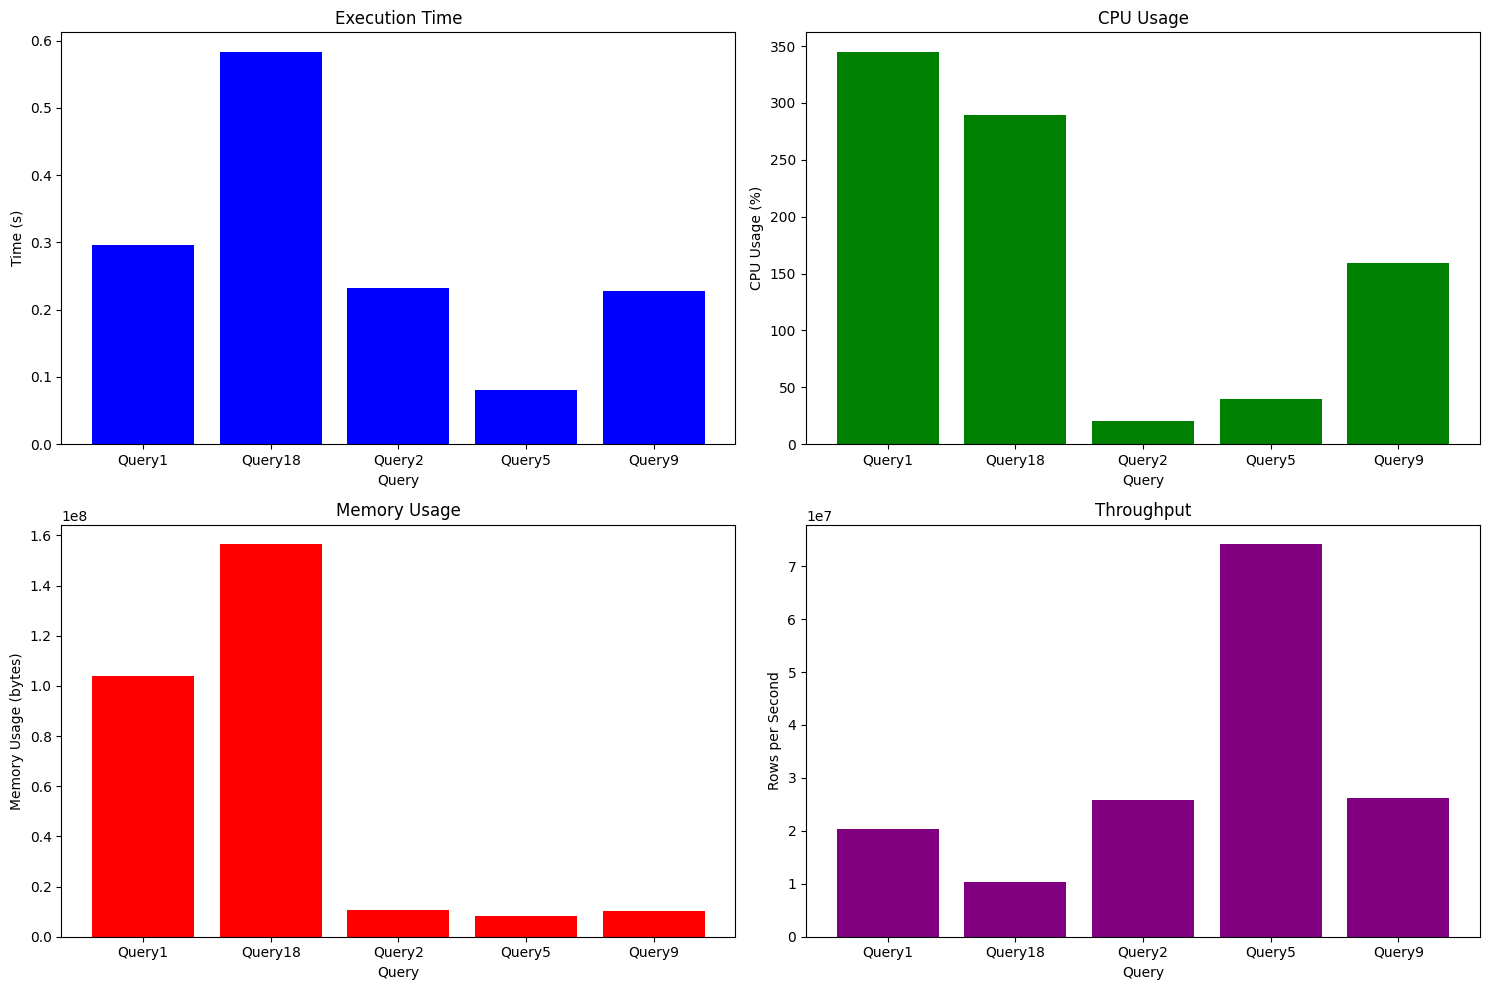

In [13]:
import time
import psutil
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to DuckDB
con = duckdb.connect()

# Load the tpch extension
con.execute("INSTALL tpch")
con.execute("LOAD tpch")

# Generate TPC-H data with a scale factor of 1
con.execute("CALL dbgen(sf=1)")

# List of TPC-H tables
tpch_tables = [
    'customer',
    'lineitem',
    'nation',
    'orders',
    'part',
    'partsupp',
    'region',
    'supplier'
]

# Save each table to a Parquet file
for table in tpch_tables:
    con.execute(f"COPY {table} TO '{table}.parquet' (FORMAT PARQUET)")

# Load the Parquet files back into DuckDB
for table in tpch_tables:
    con.execute(f"CREATE OR REPLACE TABLE {table} AS SELECT * FROM parquet_scan('{table}.parquet')")

# Define queries
queries = {
    "Query1": """
        SELECT
            l_returnflag,
            l_linestatus,
            SUM(l_quantity) AS sum_qty,
            SUM(l_extendedprice) AS sum_base_price,
            SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
            SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
            AVG(l_quantity) AS avg_qty,
            AVG(l_extendedprice) AS avg_price,
            AVG(l_discount) AS avg_disc,
            COUNT(*) AS count_order
        FROM
            lineitem
        WHERE
            l_shipdate <= DATE '1998-12-01' - INTERVAL 90 DAY
        GROUP BY
            l_returnflag,
            l_linestatus
        ORDER BY
            l_returnflag,
            l_linestatus;
    """,
    "Query18": """
        SELECT
            c_name,
            c_custkey,
            o_orderkey,
            o_orderdate,
            o_totalprice,
            SUM(l_quantity)
        FROM
            customer,
            orders,
            lineitem
        WHERE
            o_orderkey IN (
                SELECT
                    l_orderkey
                FROM
                    lineitem
                GROUP BY
                    l_orderkey
                HAVING
                    SUM(l_quantity) > 300
            )
            AND c_custkey = o_custkey
            AND o_orderkey = l_orderkey
        GROUP BY
            c_name,
            c_custkey,
            o_orderkey,
            o_orderdate,
            o_totalprice
        ORDER BY
            o_totalprice DESC,
            o_orderdate;
    """,
    "Query2": """
        SELECT
            s_acctbal,
            s_name,
            n_name,
            p_partkey,
            p_mfgr,
            s_address,
            s_phone,
            s_comment
        FROM
            part,
            supplier,
            partsupp,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND p_size = 15
            AND p_type LIKE '%BRASS'
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
            AND ps_supplycost = (
                SELECT
                    MIN(ps_supplycost)
                FROM
                    partsupp,
                    supplier,
                    nation,
                    region
                WHERE
                    p_partkey = ps_partkey
                    AND s_suppkey = ps_suppkey
                    AND s_nationkey = n_nationkey
                    AND n_regionkey = r_regionkey
                    AND r_name = 'EUROPE'
            )
        ORDER BY
            s_acctbal DESC,
            n_name,
            s_name,
            p_partkey;
    """,
    "Query5": """
        SELECT
            n_name,
            SUM(l_extendedprice * (1 - l_discount)) AS revenue
        FROM
            customer,
            orders,
            lineitem,
            supplier,
            nation,
            region
        WHERE
            c_custkey = o_custkey
            AND l_orderkey = o_orderkey
            AND l_suppkey = s_suppkey
            AND c_nationkey = s_nationkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'ASIA'
            AND o_orderdate >= DATE '1994-01-01'
            AND o_orderdate < DATE '1995-01-01'
        GROUP BY
            n_name
        ORDER BY
            revenue DESC;
    """,
    "Query9": """
        SELECT
            nation,
            o_year,
            SUM(amount) AS sum_profit
        FROM (
            SELECT
                n_name AS nation,
                YEAR(o_orderdate) AS o_year,
                l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
            FROM
                part,
                supplier,
                lineitem,
                partsupp,
                orders,
                nation
            WHERE
                s_suppkey = l_suppkey
                AND ps_suppkey = l_suppkey
                AND ps_partkey = l_partkey
                AND p_partkey = l_partkey
                AND o_orderkey = l_orderkey
                AND s_nationkey = n_nationkey
                AND p_name LIKE '%green%'
        ) AS profit
        GROUP BY
            nation,
            o_year
        ORDER BY
            nation,
            o_year DESC;
    """
}

# Function to measure metrics
def measure_query_performance(con, query):
    # Start measuring time
    start_time = time.time()
    
    # Start measuring CPU and Memory usage
    process = psutil.Process()
    start_cpu = process.cpu_percent(interval=None)
    start_mem = process.memory_info().rss
    
    # Execute the query
    con.execute(query).fetchdf()
    
    # End measuring CPU and Memory usage
    end_cpu = process.cpu_percent(interval=None)
    end_mem = process.memory_info().rss
    
    # End measuring time
    end_time = time.time()
    
    # Calculate metrics
    execution_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu
    memory_usage = end_mem - start_mem
    throughput = len(con.execute("SELECT * FROM lineitem").fetchdf()) / execution_time  # Number of rows per second
    
    return execution_time, cpu_usage, memory_usage, throughput

# Measure performance for each query
results = []
for query_name, query in queries.items():
    exec_time, cpu_usage, mem_usage, throughput = measure_query_performance(con, query)
    results.append({
        "Query": query_name,
        "Execution Time": exec_time,
        "CPU Usage": cpu_usage,
        "Memory Usage": mem_usage,
        "Throughput": throughput
    })

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Execution Time
axs[0, 0].bar(df["Query"], df["Execution Time"], color='blue')
axs[0, 0].set_title("Execution Time")
axs[0, 0].set_xlabel("Query")
axs[0, 0].set_ylabel("Time (s)")

# CPU Usage
axs[0, 1].bar(df["Query"], df["CPU Usage"], color='green')
axs[0, 1].set_title("CPU Usage")
axs[0, 1].set_xlabel("Query")
axs[0, 1].set_ylabel("CPU Usage (%)")

# Memory Usage
axs[1, 0].bar(df["Query"], df["Memory Usage"], color='red')
axs[1, 0].set_title("Memory Usage")
axs[1, 0].set_xlabel("Query")
axs[1, 0].set_ylabel("Memory Usage (bytes)")

# Throughput
axs[1, 1].bar(df["Query"], df["Throughput"], color='purple')
axs[1, 1].set_title("Throughput")
axs[1, 1].set_xlabel("Query")
axs[1, 1].set_ylabel("Rows per Second")

plt.tight_layout()
plt.show()
